In [1]:
dataset <- "ARPAL"
state <- "Liguria"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
scia_meta <- query_checkpoint_meta("SCIA", "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!state %in% c("Piemonte", "Emilia-Romagna", "Toscana"), !(network %in% c("Sinottica", "Mareografica")))

metas <- bind_rows(ds_meta, scia_meta) |> mutate(key = row_number()) #|> mutate(dataset = if_else(dataset == "SCIA", 2L, 1L))
metas <- copy_to(conns$data, metas, "metas_tmp", overwrite = TRUE)
matches <- close_matches(metas, 10000, conns$stations)

data <- query_checkpoint_data(c(dataset, "SCIA"), "qc1", conns$data) |>
    filter(valid) |>
    select(-starts_with("qc_"), -valid) |>
    left_join(metas |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key"))

smatches <- series_matches(data, matches, metas)


In [4]:
analysis1 <- series_matches_analysis(smatches, data, metas)


In [9]:
write_xlsx_analysis(analysis1, "notebooks/integrazioni_regionali/liguria/analysis.xlsx", starts_with("user_code"), starts_with("sensor_id"))


In [63]:
source("notebooks/integrazioni_regionali/liguria/procedures/match_taggers.R")
source("src/merging/tagging.R")
tagged_analysis <- tag_same_series(analysis1) |>
    tag_manual() |>
    tag_mergeable() |>
    default_logic(require_all = TRUE)
tagged_analysis |> write_xlsx_analysis("notebooks/integrazioni_regionali/liguria/same_series_analysis.xlsx", starts_with("user_code"), starts_with("sensor_id"), starts_with("tag_"))


In [98]:
source("src/merging/combining.R")
m <- collect(metas)
gs <- series_groups(tagged_analysis, m, data, tag_same_series, group_by_component, FALSE)
ranked_series_groups <- rank_series_groups(gs$table, m, c("ARPAL", "SCIA"), desc(dataset), desc(sensor_last))
merged <- dynamic_merge(data, ranked_series_groups, tagged_analysis, rejection_threshold = 0.8)


In [101]:
merge_rejections <- incompatible_merges(data, ranked_series_groups, tagged_analysis, cycles = 2L, rejection_threshold = 0.8)


In [102]:
merge_rejections |>
    left_join(m |> select(key, name, dataset, sensor_key), by = c("key_x" = "key")) |>
    left_join(m |> select(key, name, dataset, sensor_key), by = c("key_y" = "key"))


pkey,k0,gkey,key_x,key_y,variable,offset_days,name.x,dataset.x,sensor_key.x,name.y,dataset.y,sensor_key.y
<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
2,1.430000,1,1,2,1,0,AIROLE,ARPAL,1,AIROLE,ARPAL,2
250,-1.111919,125,164,163,1,0,STATALE,ARPAL,166,STATALE,ARPAL,165


In [103]:
sources <- merged |>
    left_join(m |> select(key, dataset), by = c("from_key" = "key")) |>
    distinct(key, variable, dataset) |>
    group_by(key, variable) |>
    summarise(source = if_else(n() > 1L, "both", first(dataset)), .groups = "drop")


In [104]:
merged_series <- merged |>
    left_join(sources, by = c("key", "variable")) |>
    rename(dataset = source, sensor_key = key)


In [105]:
source("notebooks/integrazioni_regionali/procedure/plots.R")
pp <- plot_state_avail.tbl(merged_series |> filter(year(date) >= 1990L))


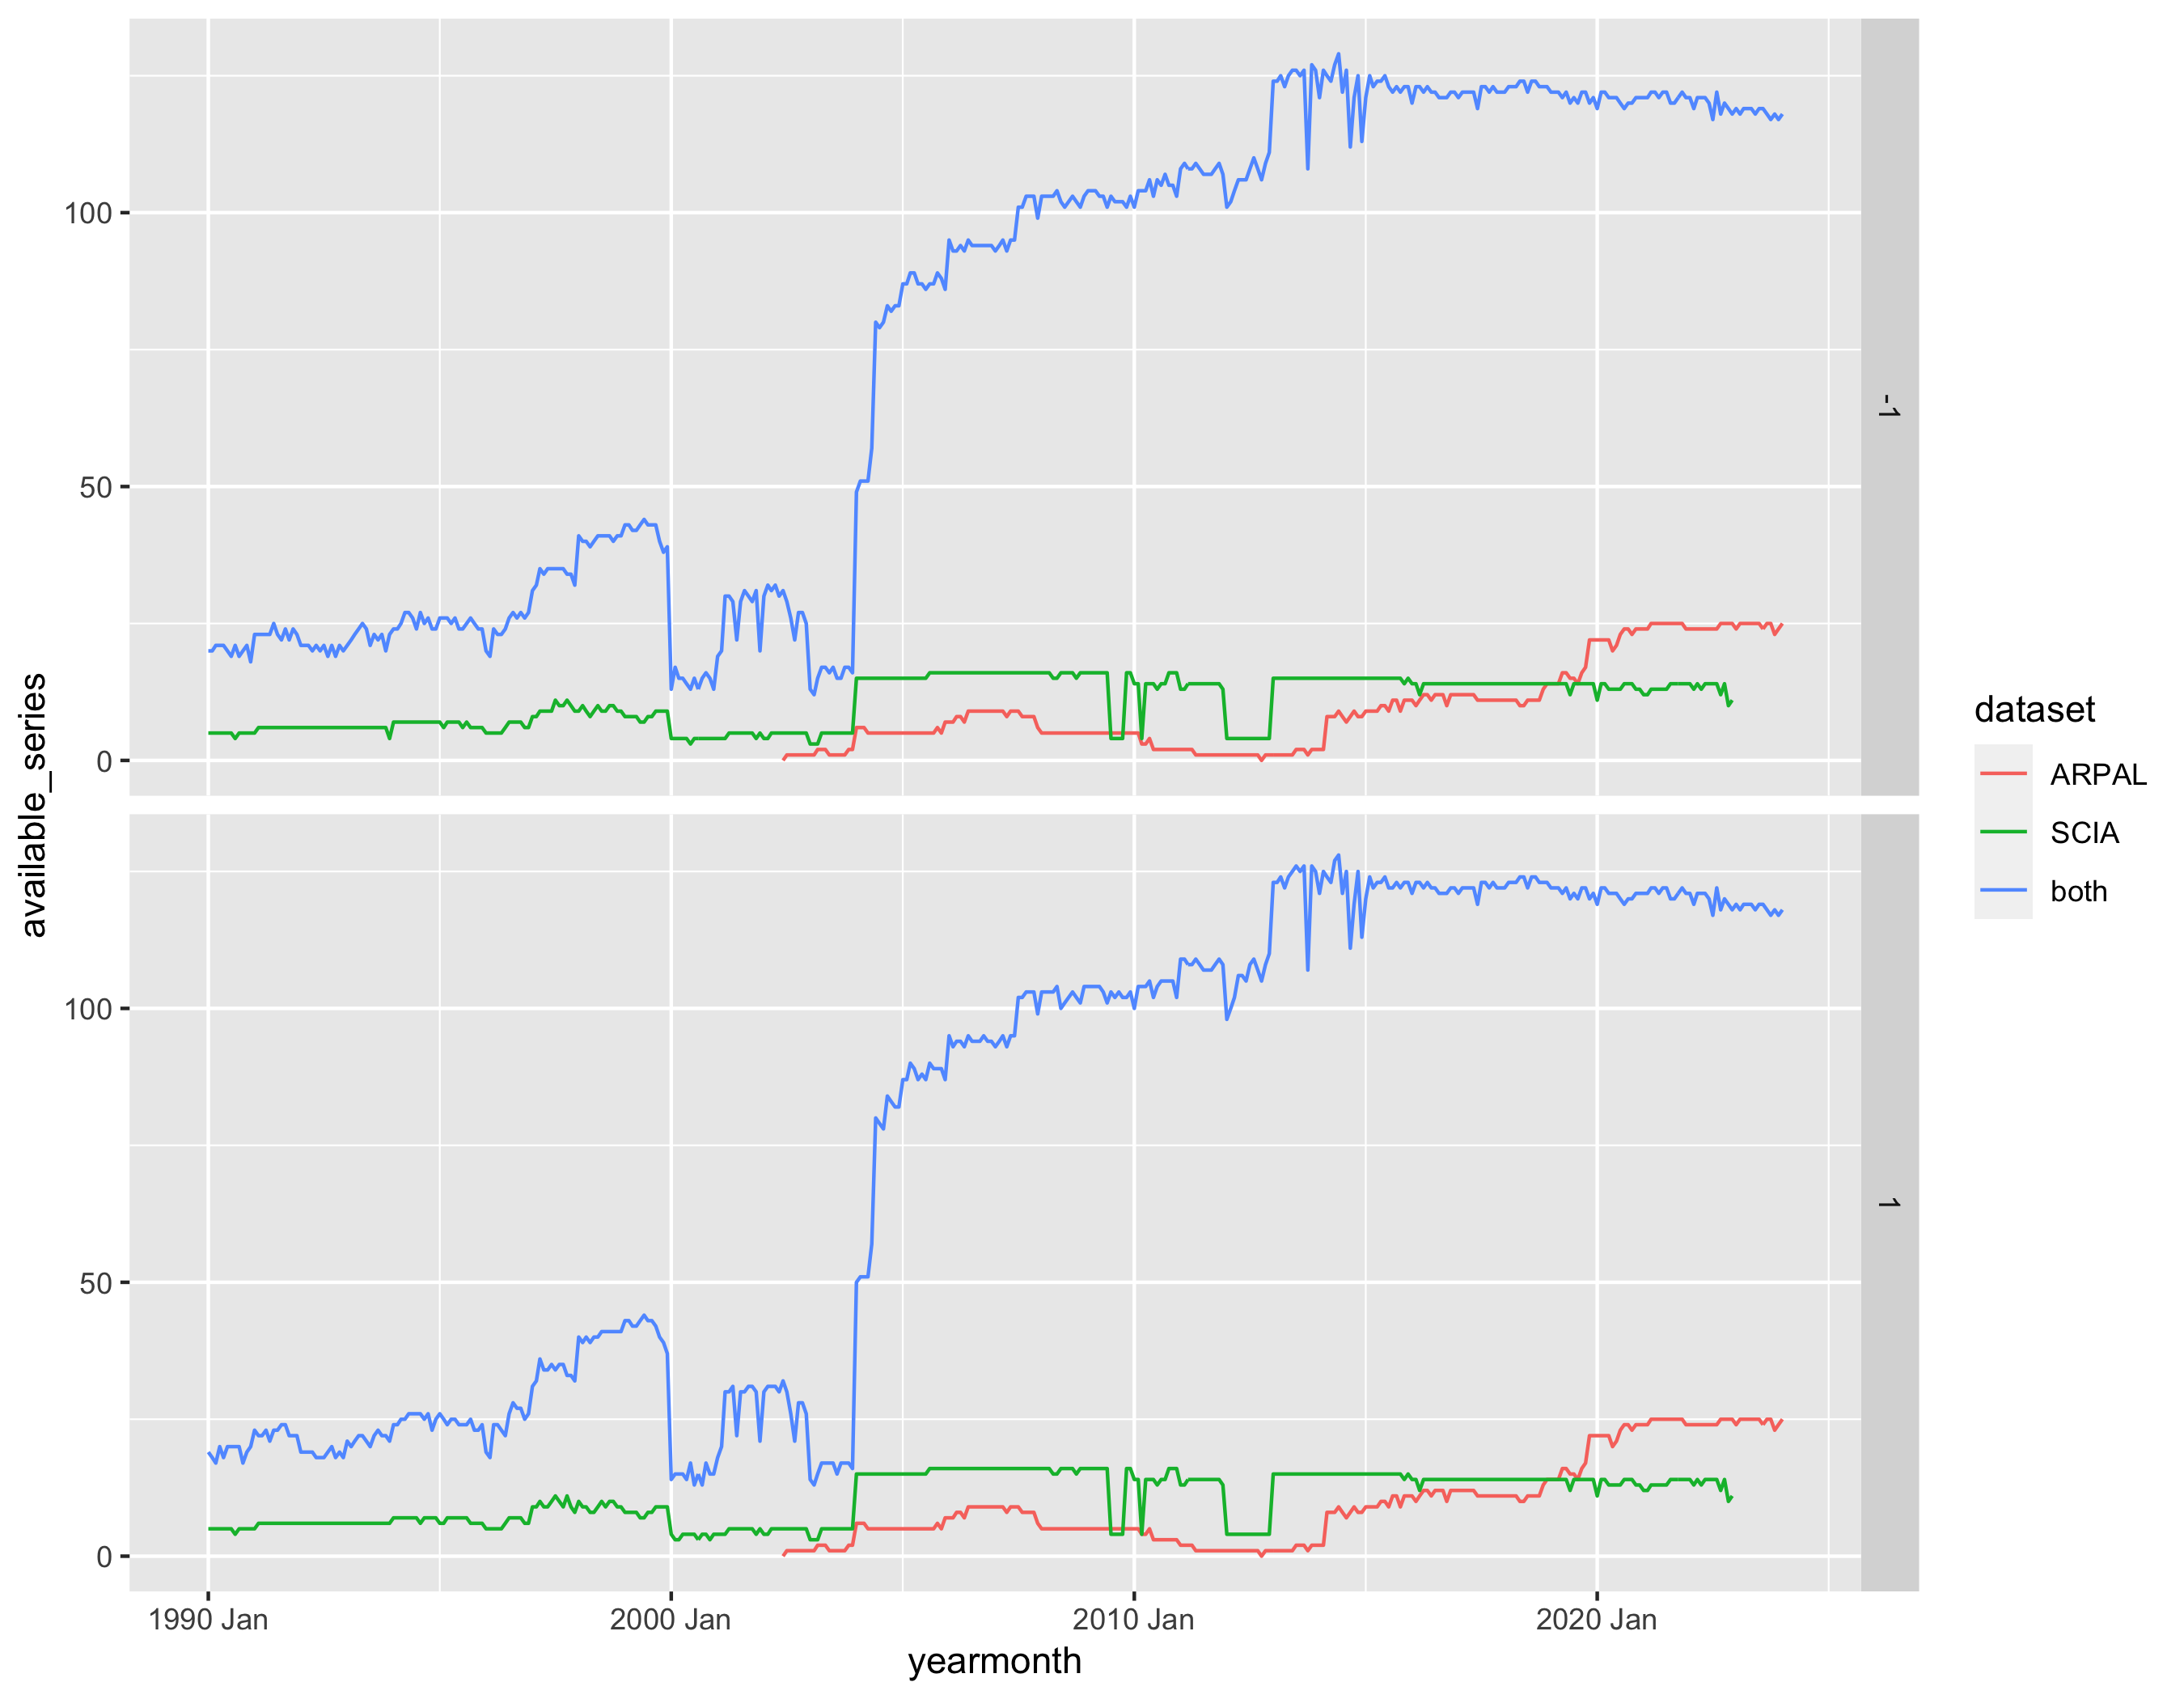

In [106]:
pp$plot + facet_grid(variable ~ .)


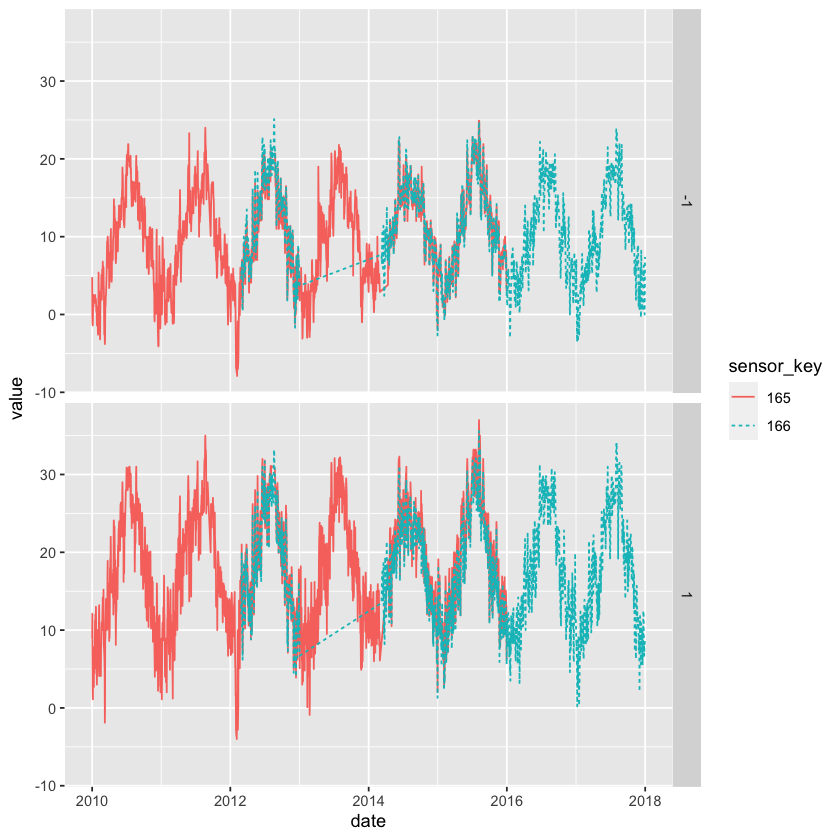

In [86]:
ids <- tibble(sensor_key = c(165L, 166L), dataset = "ARPAL")
plot_stations(ids, data |> filter(2010 <= year(date), year(date) <= 2017 ), same_period = FALSE)